Initializing Packages

In [1259]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

In [1260]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

directory = "team_battery/Mixed_up_spec_files"

# Regex: ba_<gain>_<voltage>.mca  e.g. ba_4_1659.mca
pattern = re.compile(r"fe_(\d+)_(\d+)\.mca")

# Temporary storage: (gain, voltage, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        gain = float(match.group(1))      # first number
        voltage = float(match.group(2))   # second number
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((gain, voltage, data))

# Sort by gain, then by voltage (both ascending)
temp_storage.sort(key=lambda item: (item[0], item[1]))  # multi-key sort [web:45][web:47]

# Split into separate lists
file_gains     = [item[0] for item in temp_storage]
file_labels  = [item[1] for item in temp_storage]
all_data_lists = [item[2] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of gain, then voltage.\n")

# Print gain and voltage for each file
for i, (g, v) in enumerate(zip(file_gains, file_labels), start=1):
    print(f"File {i}: gain = {g}, voltage = {v}")

Loaded 22 files in ascending order of gain, then voltage.

File 1: gain = 2.0, voltage = 2168.0
File 2: gain = 2.0, voltage = 2228.0
File 3: gain = 2.0, voltage = 2288.0
File 4: gain = 2.0, voltage = 2348.0
File 5: gain = 4.0, voltage = 2048.0
File 6: gain = 4.0, voltage = 2108.0
File 7: gain = 4.0, voltage = 2168.0
File 8: gain = 10.0, voltage = 1928.0
File 9: gain = 10.0, voltage = 1988.0
File 10: gain = 10.0, voltage = 2048.0
File 11: gain = 20.0, voltage = 1748.0
File 12: gain = 20.0, voltage = 1808.0
File 13: gain = 20.0, voltage = 1868.0
File 14: gain = 20.0, voltage = 1928.0
File 15: gain = 40.0, voltage = 1568.0
File 16: gain = 40.0, voltage = 1628.0
File 17: gain = 40.0, voltage = 1688.0
File 18: gain = 40.0, voltage = 1748.0
File 19: gain = 100.0, voltage = 1388.0
File 20: gain = 100.0, voltage = 1448.0
File 21: gain = 100.0, voltage = 1508.0
File 22: gain = 100.0, voltage = 1568.0


In [1261]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')

In [1262]:
index=3
minimum_expected_peak_height=40
minimum_bin_distance_between_peaks=100
minimum_peak_width=8
maximum_peak_width=200
minimum_peak_prominence=None
# threshold=13

channel_no=np.linspace(0,len(all_data_lists[index]),1024)

In [1263]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

In [1264]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [1265]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess,maxfev=5000)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [1266]:
def peak_scouter(index,
                 minimum_expected_peak_height,
                 minimum_bin_distance_between_peaks,
                 minimum_peak_width,
                 maximum_peak_width,
                 minimum_peak_prominence,
                 bkg,
                 all_data_lists):

    peak_pnts = []
    range_list = []
    p0_list = []
    bkg_corr_ind = bkg_corrector(bkg, all_data_lists, index)
    
    # Find all peaks
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,
        distance=minimum_bin_distance_between_peaks,
        width=(minimum_peak_width, maximum_peak_width),
        prominence=minimum_peak_prominence,
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_heights = properties["peak_heights"]
    peak_positions = channel_no[peak_bins]
    peak_widths = properties["widths"]
    
    # ---- keep ONLY the single highest peak ----
    if len(peak_heights) > 0:
        top_idx = np.argmax(peak_heights)      # index of max height
        peak_bins = peak_bins[top_idx:top_idx+1]
        peak_heights = peak_heights[top_idx:top_idx+1]
        peak_positions = peak_positions[top_idx:top_idx+1]
        peak_widths = peak_widths[top_idx:top_idx+1]
    # -------------------------------------------

    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_pnts.append(bkg_corr_ind[i])
    
    for i in range(len(peak_bins)):  # now at most 1
        # default auto range from width
        lower_lim = peak_bins[i] - 2 * peak_widths[i]
        upper_lim = peak_bins[i] + 2 * peak_widths[i]
        fit_range = [int(lower_lim + 1), int(upper_lim + 1)]

        # --- custom range ONLY for the third graph (index == 2) ---
        # replace [300, 420] with your desired channel window
        if index == 3:
            fit_range = [650, 1000]
        # ----------------------------------------------------------

        range_list.append(fit_range)
        
        a_est = peak_heights[i]
        mu_est = peak_positions[i]
        sigma_est = peak_widths[i]
        init_guess = [a_est, mu_est, sigma_est]
        p0_list.append(init_guess)
    
    return peak_pnts, peak_bins, peak_positions, peak_widths, range_list, p0_list, bkg_corr_ind

In [1267]:
def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peaks in range(0,len(range_list)):
        ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        centroid=mu[1]
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
    return ranged_channel_list, fit_gauss_list,centroid

FINAL FIT TESTING CODE


Processing bias voltage 2168.0 (Index 0)
Rough peak positions: [202.19745846]
NO. PEAKS DETECTED: 1
Peak heights: [146.]

Fitting peaks for bias voltage 2168.0:
  Peak 1: Centroid = 201.872 ± 0.282
✓ Successfully fitted 1 peaks

Processing bias voltage 2228.0 (Index 1)
Rough peak positions: [303.29618768]
NO. PEAKS DETECTED: 1
Peak heights: [104.]

Fitting peaks for bias voltage 2228.0:
  Peak 1: Centroid = 317.803 ± 0.399
✓ Successfully fitted 1 peaks

Processing bias voltage 2288.0 (Index 2)
Rough peak positions: [523.51124145]
NO. PEAKS DETECTED: 1
Peak heights: [66.]

Fitting peaks for bias voltage 2288.0:
  Peak 1: Centroid = 509.651 ± 0.672
✓ Successfully fitted 1 peaks

Processing bias voltage 2348.0 (Index 3)
Rough peak positions: [818.79960899]
NO. PEAKS DETECTED: 1
Peak heights: [46.]

Fitting peaks for bias voltage 2348.0:
  Peak 1: Centroid = 809.712 ± 0.975
✓ Successfully fitted 1 peaks

Processing bias voltage 2048.0 (Index 4)
Rough peak positions: [163.15933529]
NO. PEA

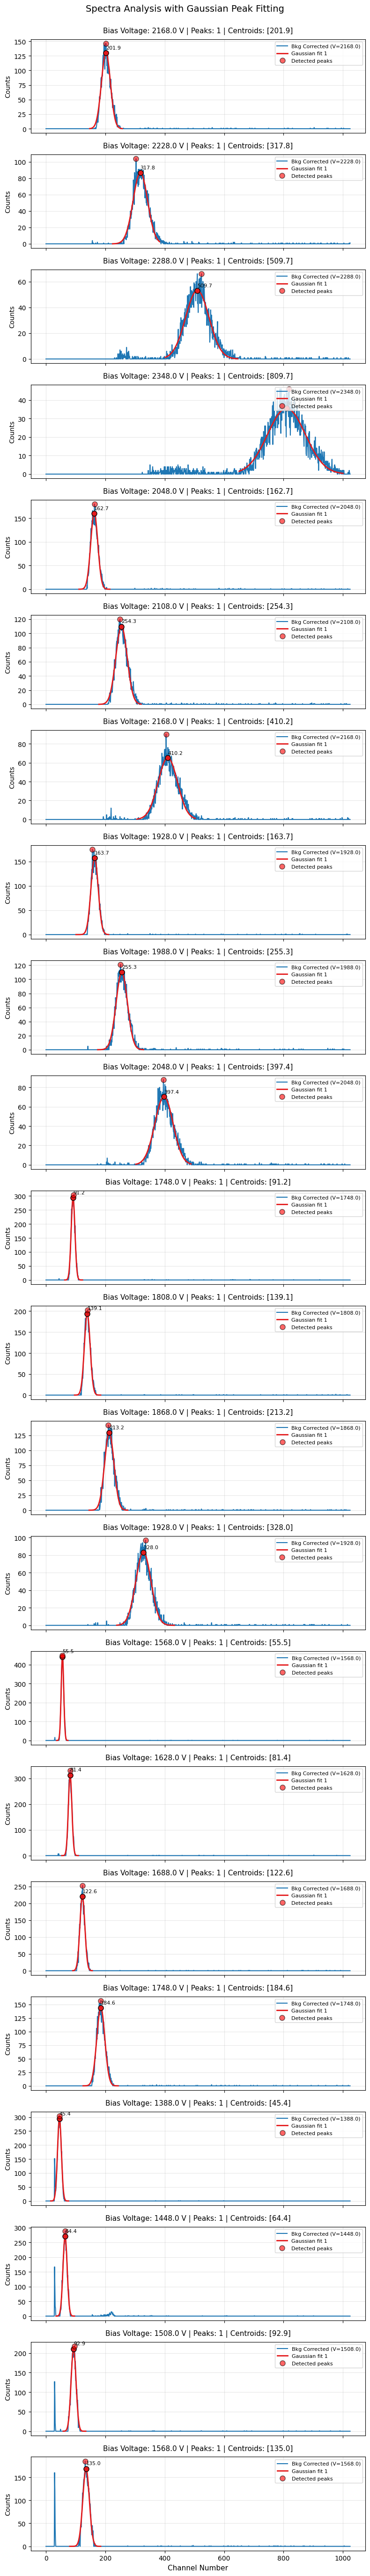


PROCESSING SUMMARY
Total spectra processed: 22
Total peaks fitted: 22

CENTROID SUMMARY

Spectrum 0 (Bias Voltage: 2168.0):
  Peak 1: Centroid = 201.872 ± 0.282

Spectrum 1 (Bias Voltage: 2228.0):
  Peak 1: Centroid = 317.803 ± 0.399

Spectrum 2 (Bias Voltage: 2288.0):
  Peak 1: Centroid = 509.651 ± 0.672

Spectrum 3 (Bias Voltage: 2348.0):
  Peak 1: Centroid = 809.712 ± 0.975

Spectrum 4 (Bias Voltage: 2048.0):
  Peak 1: Centroid = 162.653 ± 0.206

Spectrum 5 (Bias Voltage: 2108.0):
  Peak 1: Centroid = 254.271 ± 0.300

Spectrum 6 (Bias Voltage: 2168.0):
  Peak 1: Centroid = 410.208 ± 0.548

Spectrum 7 (Bias Voltage: 1928.0):
  Peak 1: Centroid = 163.730 ± 0.210

Spectrum 8 (Bias Voltage: 1988.0):
  Peak 1: Centroid = 255.264 ± 0.285

Spectrum 9 (Bias Voltage: 2048.0):
  Peak 1: Centroid = 397.365 ± 0.490

Spectrum 10 (Bias Voltage: 1748.0):
  Peak 1: Centroid = 91.229 ± 0.111

Spectrum 11 (Bias Voltage: 1808.0):
  Peak 1: Centroid = 139.104 ± 0.168

Spectrum 12 (Bias Voltage: 1868.0

In [1268]:
def plot_all_spectra_with_fits(all_data_lists, bkg, file_labels):
    n = len(all_data_lists)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n), sharex=True)
    if n == 1:
        axes = [axes]

    all_fit_ranges = []
    all_fit_results = []
    all_centroids = []        # per-spectrum centroids
    all_centroid_errors = []  # per-spectrum errors

    for idx in range(n):
        print(f"\n{'='*50}")
        print(f"Processing bias voltage {file_labels[idx]} (Index {idx})")
        print(f"{'='*50}")
        ax = axes[idx]

        bkg_corr = bkg_corrector(bkg, all_data_lists, idx)

        (peak_pnts, peak_bins, peak_positions,
         peak_width, range_list, p0_list, bkg_corr_ind) = peak_scouter(
            idx,
            minimum_expected_peak_height,
            minimum_bin_distance_between_peaks,
            minimum_peak_width,
            maximum_peak_width,
            minimum_peak_prominence,
            bkg,
            all_data_lists
        )

        this_fit_ranges = [[float(r[0]), float(r[1])] for r in range_list]
        all_fit_ranges.append(this_fit_ranges)
        
        ax.plot(channel_no, bkg_corr, label=f"Bkg Corrected (V={file_labels[idx]})",
                color="C0", linewidth=1.5)

        spectrum_centroids = []
        spectrum_centroid_errors = []

        if len(peak_positions) > 0:
            print(f"\nFitting peaks for bias voltage {file_labels[idx]}:")
            
            spectrum_fit_results = []
            ranged_channel_list = []
            fit_gauss_list = []
            
            for i, (fit_range, init_guess) in enumerate(zip(range_list, p0_list)):
                ranged_channel, fit_gauss, mu, cov = peak_fitter(
                    gaussian, channel_no, bkg_corr_ind, fit_range, init_guess
                )
                
                centroid = mu[1]
                centroid_error = np.sqrt(np.diag(cov))[1]
                
                spectrum_centroids.append(centroid)
                spectrum_centroid_errors.append(centroid_error)
                
                ranged_channel_list.append(ranged_channel)
                fit_gauss_list.append(fit_gauss)
                
                print(f"  Peak {i+1}: Centroid = {centroid:.3f} ± {centroid_error:.3f}")
            
            all_centroids.append(spectrum_centroids)
            all_centroid_errors.append(spectrum_centroid_errors)
            
            for i, (ranged_channel, fit_gauss) in enumerate(zip(ranged_channel_list, fit_gauss_list)):
                spectrum_fit_results.append({
                    'channel_range': [ranged_channel[0], ranged_channel[-1]],
                    'fitted_gaussian': fit_gauss,
                    'centroid': spectrum_centroids[i],
                    'centroid_error': spectrum_centroid_errors[i]
                })
            all_fit_results.append(spectrum_fit_results)

            colors = plt.cm.Set1(np.linspace(0, 1, len(fit_gauss_list)))
            for i, (ranged_channel, fit_gauss, color) in enumerate(zip(ranged_channel_list, fit_gauss_list, colors)):
                ax.plot(ranged_channel, fit_gauss, color=color, linewidth=2, 
                        label=f'Gaussian fit {i+1}' if i < 5 else '')
                
                centroid = spectrum_centroids[i]
                fit_max = np.max(fit_gauss)
                ax.plot(centroid, fit_max, 'o', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=1)
                
                ax.text(centroid, fit_max + fit_max*0.05, f'{centroid:.1f}', 
                        fontsize=8, ha='left', color='black')

        for bin_idx, peak_height in zip(peak_bins, peak_pnts):
            x = channel_no[bin_idx]
            y = peak_height
            ax.plot(x, y, "ro", markersize=8, alpha=0.6, markeredgecolor='black', 
                    label='Detected peaks' if bin_idx == peak_bins[0] else '')

        ax.set_ylabel("Counts", fontsize=10)
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8)
        
        title = f"Bias Voltage: {file_labels[idx]} V | Peaks: {len(peak_positions)}"
        if len(peak_positions) > 0 and spectrum_centroids:
            centroids_str = ', '.join([f'{c:.1f}' for c in spectrum_centroids])
            title += f" | Centroids: [{centroids_str}]"
        
        ax.set_title(title, fontsize=11, pad=10)
        ax.grid(True, alpha=0.3)

        print(f"✓ Successfully fitted {len(spectrum_centroids)} peaks")

    axes[-1].set_xlabel("Channel Number", fontsize=11)
    plt.suptitle("Spectra Analysis with Gaussian Peak Fitting", fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print(f"{'='*60}")
    total_peaks = sum(len(c) for c in all_centroids)
    print(f"Total spectra processed: {n}")
    print(f"Total peaks fitted: {total_peaks}")
    
    print(f"\n{'='*60}")
    print("CENTROID SUMMARY")
    print(f"{'='*60}")
    for idx, (centroids, errors) in enumerate(zip(all_centroids, all_centroid_errors)):
        print(f"\nSpectrum {idx} (Bias Voltage: {file_labels[idx]}):")
        for i, (c, e) in enumerate(zip(centroids, errors)):
            print(f"  Peak {i+1}: Centroid = {c:.3f} ± {e:.3f}")
    
    print(f"\n{'='*60}")
    print("CENTROIDS ONLY (for easy copying):")
    print(f"{'='*60}")
    print("all_centroids = [")
    for idx, centroids in enumerate(all_centroids):
        if centroids:
            centroid_list = [f"{c:.3f}" for c in centroids]
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): {centroid_list},")
        else:
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): [],")
    print("]")

    # NEW: flatten to 1D arrays
    flat_centroids = np.array([c for spec in all_centroids for c in spec])
    flat_centroid_errors = np.array([e for spec in all_centroid_errors for e in spec])

    return all_fit_ranges,all_fit_results,all_centroids,all_centroid_errors,flat_centroids,flat_centroid_errors

# Updated call:
fit_ranges,fit_results,all_centroids,all_centroid_errors,flat_centroids,flat_centroid_errors = plot_all_spectra_with_fits(all_data_lists, bkg, file_labels)


PLOTTING THE COMBINED HISTOGRAMS

In [1269]:
# def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
#     bkg_correction=bkg_corrector(bkg,data_list,index)
#     # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
#     plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
#     # plt.xlim(0,100)
#     plt.title("Fe55 Combined Histograms (Background corrected)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     # plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [1270]:
# def hist_generator(index,data_list,label_list,color):
#     plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index],color=color)
#     # plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     # plt.xlim(0,100)
#     plt.title("Fe55 Combined Histograms (No background correction)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

In [1271]:
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1040*(channels[i]) - 0.4074
        if energy>0:
            energy_list.append(energy)
    return energy_list

In [1272]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color,channels):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,bkg_correction[-(len(energy_list)):],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.title("Fe55 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')

In [1273]:
def hist_generator(index,data_list,bkg,label_list,color,channels):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,data_list[index][-(len(energy_list)):],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.title("Fe55 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')
    

In [1274]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

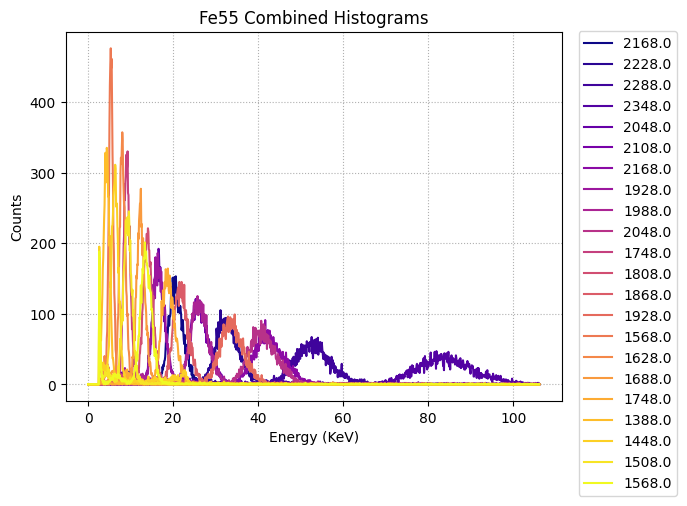

In [1275]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,bkg,file_labels,colour[i],channel_no)

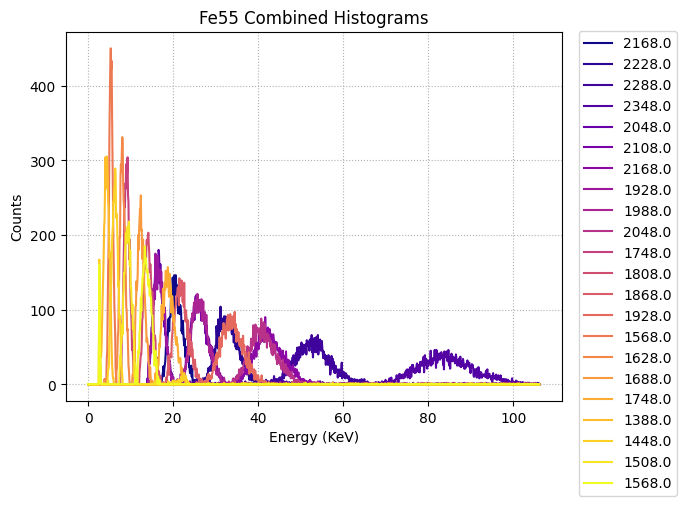

In [1276]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i],channel_no)
    

Trying to plot the operational region plots

In [1277]:
def charge_cali(channels):
    charge_list=[]
    no_e_list=[]
    e=1.6e-19
    for i in range(0,len(channels)):
        charge= (1.751e-13*channels[i]) + 1.164e-12
        no_e=charge/e
        charge_list.append(charge)
        no_e_list.append(no_e)
    return charge_list, no_e_list

22
[0.28207276 0.39870448 0.67228396 0.97472111 0.20615242 0.30003119
 0.54825789 0.20977363 0.28541709 0.48981461 0.1109073  0.1683852
 0.28228272 0.38169616 0.05881407 0.10871968 0.17428774 0.2308594
 0.23362589 0.10798126 0.1332812  0.17630818]
12608552.07281561


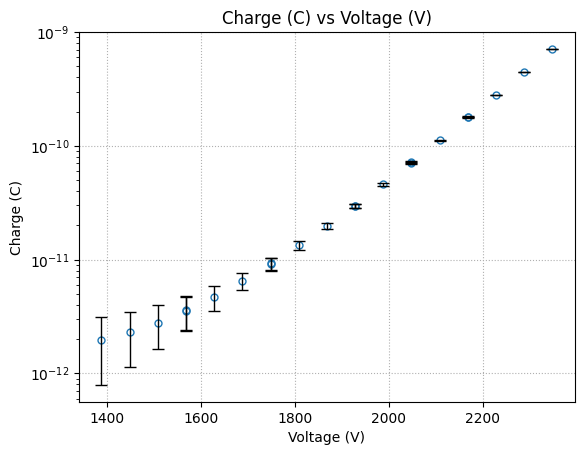

In [1278]:

gain_2_10=[0.2]*4
gain_4_10=[0.4]*3
gain_10_10=[1]*3
gain_20_10=[2]*4
gain_40_10=[4]*4
gain_100_10=[10]*4
print(len(file_labels))
n_o=227


centroid_gain_corr = (gain_2_10+gain_4_10+gain_10_10+gain_20_10+gain_40_10+gain_100_10)

gain_corr_centroids=[flat_centroids[i]/centroid_gain_corr[i] for i in range(0,len(flat_centroids))]
gain_corr_centroid_errs=[flat_centroid_errors[i]/centroid_gain_corr[i] for i in range(0,len(flat_centroid_errors))]

print(flat_centroid_errors)

charge_cali_cents,no_e_list=charge_cali(gain_corr_centroids)
charge_cali_err,no_e_list_err=charge_cali(gain_corr_centroid_errs)
print(np.max(no_e_list_err))
plt.plot(file_labels,charge_cali_cents,marker='o',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,charge_cali_cents,yerr=charge_cali_err,linestyle='none',color='black', capsize=4, capthick=1,elinewidth=1)
plt.ylabel("Charge (C)")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("Charge (C) vs Voltage (V)")
plt.grid(True, linestyle=':')
# print(no_e_list)
# plt.xlim(1400,1700)
# id1,id2=7,8
# print(file_labels[id1],file_labels[id2])
# print(charge_cali_cents[id1],charge_cali_cents[id2])


In [1279]:
# plt.plot(file_labels,no_e_list,marker='o',ms=5,linestyle='None',fillstyle='none')
# plt.errorbar(file_labels,no_e_list,yerr=no_e_list_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
# plt.ylabel("No. of electrons")  
# plt.xlabel("Voltage (V)")
# plt.yscale("log")
# plt.title("No. of electrons vs Voltage (V)")
# plt.grid(True, linestyle=':')
# plt.show()

In [1280]:
def exponential(x,s,t):
    return np.exp((s*x)+t)

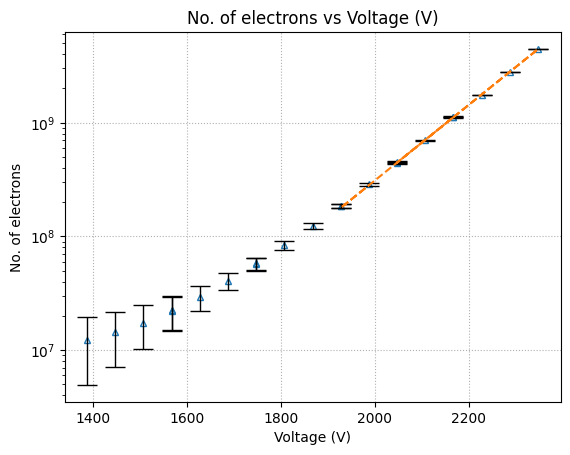

In [1281]:
log_no_e_list=np.log(no_e_list)
p0=np.polyfit(file_labels,log_no_e_list,1)
exp_fit=sci.curve_fit(exponential,file_labels,no_e_list,p0=p0)
s,t=exp_fit[0][0],exp_fit[0][1]
fit_exp=[exponential(file_labels[i],s,t) for i in range(0,len(file_labels))]

plt.plot(file_labels,no_e_list,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,no_e_list,yerr=no_e_list_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')

plt.ylabel("No. of electrons")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("No. of electrons vs Voltage (V)")
plt.show()

In [1282]:
def gas_multiplication_factor(charge_cent,No):
    e=1.6e-19
    return [charge_cent[i]/(No*e) for i in range(0,len(charge_cent))]

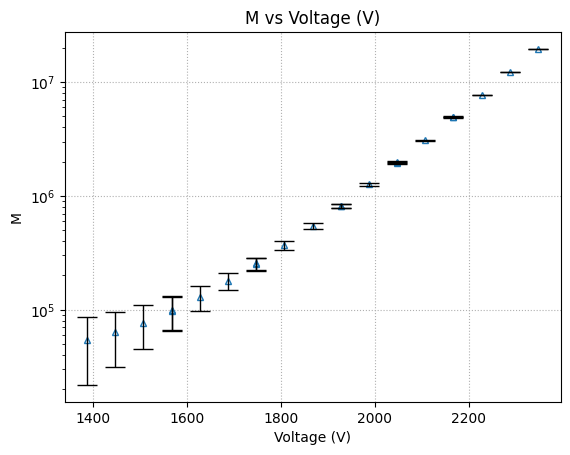

In [1283]:

gas_mult_list=gas_multiplication_factor(charge_cali_cents,n_o)
gas_mult_err=gas_multiplication_factor(charge_cali_err,n_o)
plt.plot(file_labels,gas_mult_list,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,gas_mult_list,yerr=gas_mult_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
# plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')
plt.ylabel("M")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("M vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.show()


### FE55


In [1284]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

Section 1: Loading in the data and storing it as lists

In [1285]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

directory = "team_battery/Mixed_up_spec_files"

# Regex: ba_<gain>_<voltage>.mca  e.g. ba_4_1659.mca
pattern = re.compile(r"ba_(\d+)_(\d+)\.mca")

# Temporary storage: (gain, voltage, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        gain = float(match.group(1))      # first number
        voltage = float(match.group(2))   # second number
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((gain, voltage, data))

# Sort by gain, then by voltage (both ascending)
temp_storage.sort(key=lambda item: (item[0], item[1]))  # multi-key sort [web:45][web:47]

# Split into separate lists
file_gains     = [item[0] for item in temp_storage]
file_labels_fe  = [item[1] for item in temp_storage]
all_data_lists_fe = [item[2] for item in temp_storage]

print(f"Loaded {len(all_data_lists_fe)} files in ascending order of gain, then voltage.\n")

# Print gain and voltage for each file
for i, (g, v) in enumerate(zip(file_gains, file_labels_fe), start=1):
    print(f"File {i}: gain = {g}, voltage = {v}")

Loaded 24 files in ascending order of gain, then voltage.

File 1: gain = 2.0, voltage = 1760.0
File 2: gain = 2.0, voltage = 1809.0
File 3: gain = 2.0, voltage = 1859.0
File 4: gain = 2.0, voltage = 1910.0
File 5: gain = 2.0, voltage = 1960.0
File 6: gain = 2.0, voltage = 2010.0
File 7: gain = 2.0, voltage = 2121.0
File 8: gain = 4.0, voltage = 1659.0
File 9: gain = 4.0, voltage = 1709.0
File 10: gain = 4.0, voltage = 1760.0
File 11: gain = 10.0, voltage = 1559.0
File 12: gain = 10.0, voltage = 1610.0
File 13: gain = 10.0, voltage = 1659.0
File 14: gain = 20.0, voltage = 1459.0
File 15: gain = 20.0, voltage = 1509.0
File 16: gain = 20.0, voltage = 1559.0
File 17: gain = 40.0, voltage = 1309.0
File 18: gain = 40.0, voltage = 1359.0
File 19: gain = 40.0, voltage = 1410.0
File 20: gain = 40.0, voltage = 1459.0
File 21: gain = 100.0, voltage = 1157.0
File 22: gain = 100.0, voltage = 1207.0
File 23: gain = 100.0, voltage = 1258.0
File 24: gain = 100.0, voltage = 1309.0


In [1286]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')
# Initialising the background
channel_no=np.linspace(0,len(all_data_lists[0]),1024)

Creating functions to run withing loops (The names are self explainatory)

In [1287]:

# NO THRESHOLD - MODIFIED TO DETECT ONLY 2 HIGHEST PEAKS
def peak_scouter(index, minimum_expected_peak_height, minimum_bin_distance_between_peaks, minimum_peak_width, maximum_peak_width, minimum_peak_prominence, bkg, all_data_lists):
    peak_pnts = []
    range_list = []
    p0_list = []
    bkg_corr_ind = bkg_corrector(bkg, all_data_lists, index)
    
    # Find all peaks first
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
        distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
        width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
        prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_heights = properties["peak_heights"]
    peak_positions = channel_no[peak_bins]
    peak_widths = properties["widths"]
    
    # Sort peaks by height (descending order) and take only the top 2
    if len(peak_heights) > 1:
        # Get indices of the 2 highest peaks
        top_indices = np.argsort(peak_heights)[-1:][::-1]  # [::-1] to get descending order
        
        # Keep only the top 2 peaks
        peak_bins = peak_bins[top_indices]
        peak_heights = peak_heights[top_indices]
        peak_positions = peak_positions[top_indices]
        peak_widths = peak_widths[top_indices]
    
    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_ind = bkg_corr_ind[i]
        peak_pnts.append(peak_ind)
        
    for i in range(len(peak_bins)):
        lower_lim = peak_bins[i] - 2 * peak_widths[i]
        upper_lim = peak_bins[i] + 2 * peak_widths[i] 
        fit_range = [int(lower_lim + 1), int(upper_lim + 1)]
        range_list.append(fit_range)
        
        a_est = peak_heights[i]
        mu_est = peak_positions[i]
        sigma_est = peak_widths[i]
        init_guess = [a_est, mu_est, sigma_est]
        p0_list.append(init_guess)
        
    return peak_pnts, peak_bins, peak_positions, peak_widths, range_list, p0_list, bkg_corr_ind

In [1288]:
index=10
minimum_expected_peak_height=43
minimum_bin_distance_between_peaks=15
minimum_peak_width=4
maximum_peak_width=200
minimum_peak_prominence=None

channel_no=np.linspace(0,len(all_data_lists[index]),1024)

In [1289]:
def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peaks in range(0,len(range_list)):
        ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
    return ranged_channel_list, fit_gauss_list

Test section to fit and run per voltage fits

Final Histogram plotting


Processing bias voltage 1760.0 (Index 0)
Rough peak positions: [51.04985337]
NO. PEAKS DETECTED: 1
Peak heights: [983.]

Fitting peaks for bias voltage 1760.0:
  Peak 1: Centroid = 50.644 ± 0.221
✓ Successfully fitted 1 peaks

Processing bias voltage 1809.0 (Index 1)
Rough peak positions: [71.06940371]
NO. PEAKS DETECTED: 1
Peak heights: [703.]

Fitting peaks for bias voltage 1809.0:
  Peak 1: Centroid = 70.491 ± 0.248
✓ Successfully fitted 1 peaks

Processing bias voltage 1859.0 (Index 2)
Rough peak positions: [101.09872923]
NO. PEAKS DETECTED: 1
Peak heights: [486.]

Fitting peaks for bias voltage 1859.0:
  Peak 1: Centroid = 100.554 ± 0.279
✓ Successfully fitted 1 peaks

Processing bias voltage 1910.0 (Index 3)
Rough peak positions: [145.14173998]
NO. PEAKS DETECTED: 1
Peak heights: [341.]

Fitting peaks for bias voltage 1910.0:
  Peak 1: Centroid = 144.149 ± 0.316
✓ Successfully fitted 1 peaks

Processing bias voltage 1960.0 (Index 4)
Rough peak positions: [207.20234604]
NO. PEAKS

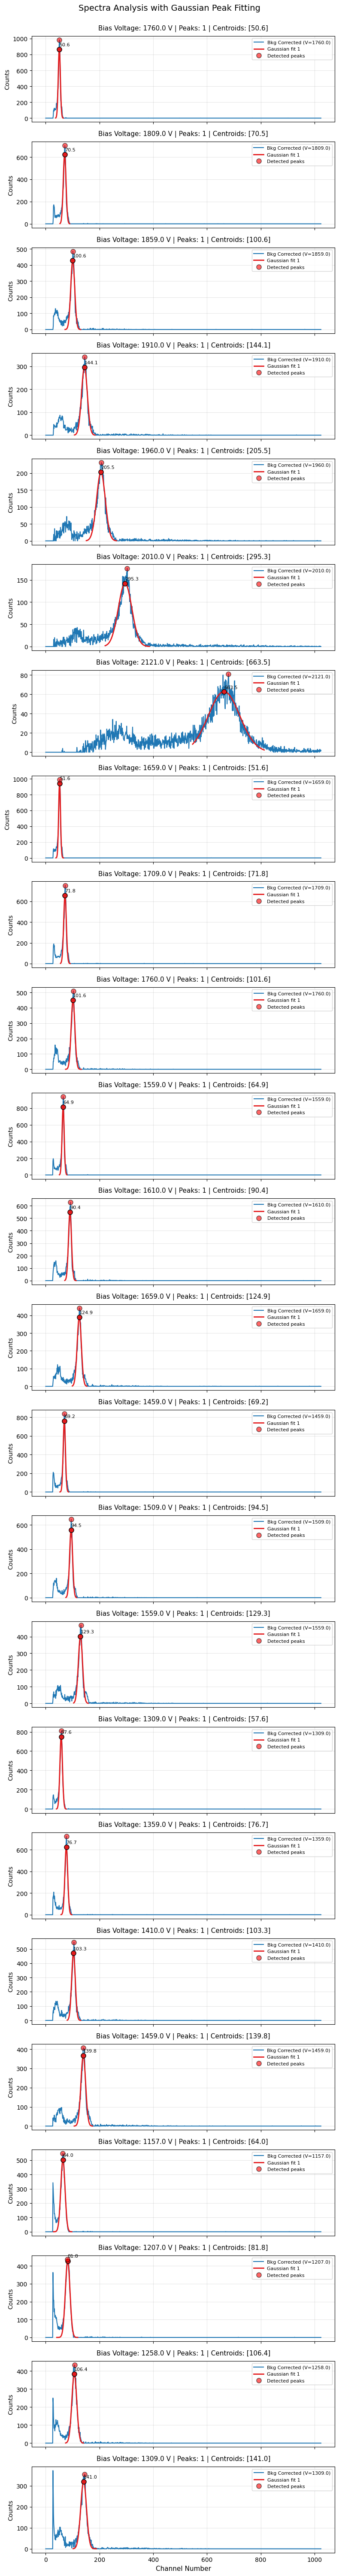


PROCESSING SUMMARY
Total spectra processed: 24
Total peaks fitted: 24

CENTROID SUMMARY

Spectrum 0 (Bias Voltage: 1760.0):
  Peak 1: Centroid = 50.644 ± 0.221

Spectrum 1 (Bias Voltage: 1809.0):
  Peak 1: Centroid = 70.491 ± 0.248

Spectrum 2 (Bias Voltage: 1859.0):
  Peak 1: Centroid = 100.554 ± 0.279

Spectrum 3 (Bias Voltage: 1910.0):
  Peak 1: Centroid = 144.149 ± 0.316

Spectrum 4 (Bias Voltage: 1960.0):
  Peak 1: Centroid = 205.491 ± 0.418

Spectrum 5 (Bias Voltage: 2010.0):
  Peak 1: Centroid = 295.305 ± 0.520

Spectrum 6 (Bias Voltage: 2121.0):
  Peak 1: Centroid = 663.470 ± 0.877

Spectrum 7 (Bias Voltage: 1659.0):
  Peak 1: Centroid = 51.613 ± 0.189

Spectrum 8 (Bias Voltage: 1709.0):
  Peak 1: Centroid = 71.847 ± 0.252

Spectrum 9 (Bias Voltage: 1760.0):
  Peak 1: Centroid = 101.638 ± 0.244

Spectrum 10 (Bias Voltage: 1559.0):
  Peak 1: Centroid = 64.869 ± 0.238

Spectrum 11 (Bias Voltage: 1610.0):
  Peak 1: Centroid = 90.350 ± 0.255

Spectrum 12 (Bias Voltage: 1659.0):
  

In [1290]:
def plot_all_spectra_with_fits(all_data_lists, bkg, file_labels):
    n = len(all_data_lists)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n), sharex=True)
    if n == 1:
        axes = [axes]

    all_fit_ranges = []
    all_fit_results = []
    all_centroids = []        # per-spectrum centroids
    all_centroid_errors = []  # per-spectrum errors

    for idx in range(n):
        print(f"\n{'='*50}")
        print(f"Processing bias voltage {file_labels[idx]} (Index {idx})")
        print(f"{'='*50}")
        ax = axes[idx]

        bkg_corr = bkg_corrector(bkg, all_data_lists, idx)

        (peak_pnts, peak_bins, peak_positions,
         peak_width, range_list, p0_list, bkg_corr_ind) = peak_scouter(
            idx,
            minimum_expected_peak_height,
            minimum_bin_distance_between_peaks,
            minimum_peak_width,
            maximum_peak_width,
            minimum_peak_prominence,
            bkg,
            all_data_lists
        )

        this_fit_ranges = [[float(r[0]), float(r[1])] for r in range_list]
        all_fit_ranges.append(this_fit_ranges)
        
        ax.plot(channel_no, bkg_corr, label=f"Bkg Corrected (V={file_labels[idx]})",
                color="C0", linewidth=1.5)

        spectrum_centroids = []
        spectrum_centroid_errors = []

        if len(peak_positions) > 0:
            print(f"\nFitting peaks for bias voltage {file_labels[idx]}:")
            
            spectrum_fit_results = []
            ranged_channel_list = []
            fit_gauss_list = []
            
            for i, (fit_range, init_guess) in enumerate(zip(range_list, p0_list)):
                ranged_channel, fit_gauss, mu, cov = peak_fitter(
                    gaussian, channel_no, bkg_corr_ind, fit_range, init_guess
                )
                
                centroid = mu[1]
                centroid_error = np.sqrt(np.diag(cov))[1]
                
                spectrum_centroids.append(centroid)
                spectrum_centroid_errors.append(centroid_error)
                
                ranged_channel_list.append(ranged_channel)
                fit_gauss_list.append(fit_gauss)
                
                print(f"  Peak {i+1}: Centroid = {centroid:.3f} ± {centroid_error:.3f}")
            
            all_centroids.append(spectrum_centroids)
            all_centroid_errors.append(spectrum_centroid_errors)
            
            for i, (ranged_channel, fit_gauss) in enumerate(zip(ranged_channel_list, fit_gauss_list)):
                spectrum_fit_results.append({
                    'channel_range': [ranged_channel[0], ranged_channel[-1]],
                    'fitted_gaussian': fit_gauss,
                    'centroid': spectrum_centroids[i],
                    'centroid_error': spectrum_centroid_errors[i]
                })
            all_fit_results.append(spectrum_fit_results)

            colors = plt.cm.Set1(np.linspace(0, 1, len(fit_gauss_list)))
            for i, (ranged_channel, fit_gauss, color) in enumerate(zip(ranged_channel_list, fit_gauss_list, colors)):
                ax.plot(ranged_channel, fit_gauss, color=color, linewidth=2, 
                        label=f'Gaussian fit {i+1}' if i < 5 else '')
                
                centroid = spectrum_centroids[i]
                fit_max = np.max(fit_gauss)
                ax.plot(centroid, fit_max, 'o', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=1)
                
                ax.text(centroid, fit_max + fit_max*0.05, f'{centroid:.1f}', 
                        fontsize=8, ha='left', color='black')

        for bin_idx, peak_height in zip(peak_bins, peak_pnts):
            x = channel_no[bin_idx]
            y = peak_height
            ax.plot(x, y, "ro", markersize=8, alpha=0.6, markeredgecolor='black', 
                    label='Detected peaks' if bin_idx == peak_bins[0] else '')

        ax.set_ylabel("Counts", fontsize=10)
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8)
        
        title = f"Bias Voltage: {file_labels[idx]} V | Peaks: {len(peak_positions)}"
        if len(peak_positions) > 0 and spectrum_centroids:
            centroids_str = ', '.join([f'{c:.1f}' for c in spectrum_centroids])
            title += f" | Centroids: [{centroids_str}]"
        
        ax.set_title(title, fontsize=11, pad=10)
        ax.grid(True, alpha=0.3)

        print(f"✓ Successfully fitted {len(spectrum_centroids)} peaks")

    axes[-1].set_xlabel("Channel Number", fontsize=11)
    plt.suptitle("Spectra Analysis with Gaussian Peak Fitting", fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print(f"{'='*60}")
    total_peaks = sum(len(c) for c in all_centroids)
    print(f"Total spectra processed: {n}")
    print(f"Total peaks fitted: {total_peaks}")
    
    print(f"\n{'='*60}")
    print("CENTROID SUMMARY")
    print(f"{'='*60}")
    for idx, (centroids, errors) in enumerate(zip(all_centroids, all_centroid_errors)):
        print(f"\nSpectrum {idx} (Bias Voltage: {file_labels[idx]}):")
        for i, (c, e) in enumerate(zip(centroids, errors)):
            print(f"  Peak {i+1}: Centroid = {c:.3f} ± {e:.3f}")
    
    print(f"\n{'='*60}")
    print("CENTROIDS ONLY (for easy copying):")
    print(f"{'='*60}")
    print("all_centroids = [")
    for idx, centroids in enumerate(all_centroids):
        if centroids:
            centroid_list = [f"{c:.3f}" for c in centroids]
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): {centroid_list},")
        else:
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): [],")
    print("]")

    # NEW: flatten to 1D arrays
    flat_centroids = np.array([c for spec in all_centroids for c in spec])
    flat_centroid_errors = np.array([e for spec in all_centroid_errors for e in spec])

    return all_fit_ranges,all_fit_results,all_centroids,all_centroid_errors,flat_centroids,flat_centroid_errors

# Updated call:
fit_ranges_fe,fit_results_fe,all_centroids_fe,all_centroid_errors_fe,flat_centroids_fe,flat_centroid_errors_fe = plot_all_spectra_with_fits(all_data_lists_fe, bkg, file_labels_fe)


In [1291]:
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1040*(channels[i]) - 0.4074
        if energy>0:
            energy_list.append(energy)
    return energy_list

In [1292]:
numline=len(all_data_lists_fe)
colour=plt.cm.plasma(np.linspace(0,1,numline))

In [1293]:
def hist_generator(index,data_list,bkg,label_list,color,channels):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,data_list[index][-(len(energy_list)):],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.title("Ba133 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')


In [1294]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color,channels):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,bkg_correction[-(len(energy_list)):],label=f"corrected {label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.title("Ba133 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')


The line at 200 is just an arbitrary level I used to check if my background deletion is working

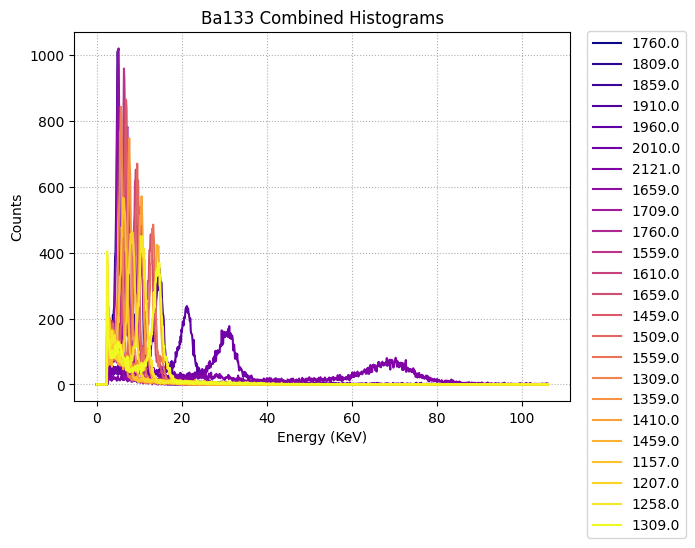

In [1295]:
for i in range(0,len(all_data_lists_fe)):
    hist_generator(i,all_data_lists_fe,bkg,file_labels_fe,colour[i],channel_no)
    

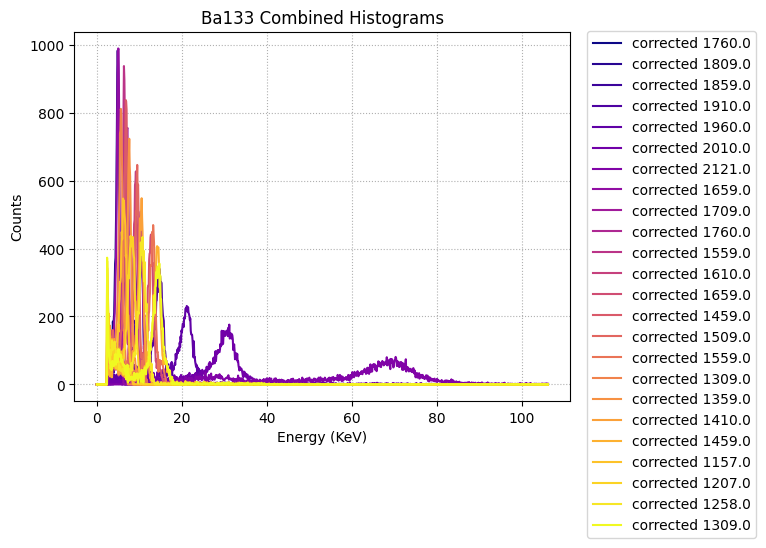

In [1296]:
for i in range(0,len(all_data_lists_fe)):
    hist_generator_bkg_corrected(i,all_data_lists_fe,bkg,file_labels_fe,colour[i],channel_no)
    

In [1297]:
def charge_cali(channels):
    charge_list=[]
    no_e_list=[]
    e=1.6e-19
    for i in range(0,len(channels)):
        charge= (1.751e-13*channels[i]) + 1.164e-12
        no_e=charge/e
        charge_list.append(charge)
        no_e_list.append(no_e)
    return charge_list, no_e_list

24
[np.float64(8482552.83705532), np.float64(8631777.85216437), np.float64(8803656.235746715), np.float64(9006449.627371907), np.float64(9560209.755639615), np.float64(10121495.146823354), np.float64(12072695.077308187), np.float64(7792791.794237194), np.float64(7964206.914730274), np.float64(7943720.448057842), np.float64(7535467.7879123455), np.float64(7553782.073752242), np.float64(7588999.643091571), np.float64(7398435.084085356), np.float64(7416288.362136666), np.float64(7449404.986888569), np.float64(7323747.859068624), np.float64(7328141.003450739), np.float64(7345407.605553278), np.float64(7356200.437426228), np.float64(7316890.679146421), np.float64(7301809.864902236), np.float64(7300288.674726219), np.float64(7301171.533022345)]
[np.float64(284391238.04552186), np.float64(392991888.597979), np.float64(557492198.5293413), np.float64(796041618.548767), np.float64(1131698339.2453678), np.float64(1623147146.6598954), np.float64(3637697428.9024086), np.float64(148486279.66533494),

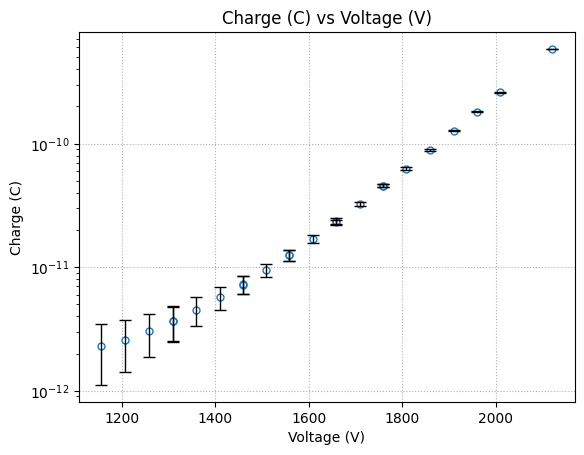

In [1298]:

gain_2_10=[0.2]*7
gain_4_10=[0.4]*3
gain_10_10=[1]*3
gain_20_10=[2]*3
gain_40_10=[4]*4
gain_100_10=[10]*4
print(len(file_labels_fe))
n_o_fe=1192

centroid_gain_corr_fe = (gain_2_10+gain_4_10+gain_10_10+gain_20_10+gain_40_10+gain_100_10)

gain_corr_centroids_fe=[flat_centroids_fe[i]/centroid_gain_corr_fe[i] for i in range(0,len(flat_centroids_fe))]
gain_corr_centroid_errs_fe=[flat_centroid_errors_fe[i]/centroid_gain_corr_fe[i] for i in range(0,len(flat_centroid_errors_fe))]

charge_cali_cents_fe,no_e_list_fe=charge_cali(gain_corr_centroids_fe)
charge_cali_err_fe,no_e_list_err_fe=charge_cali(gain_corr_centroid_errs_fe)
print(no_e_list_err_fe)
plt.plot(file_labels_fe,charge_cali_cents_fe,marker='o',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels_fe,charge_cali_cents_fe,yerr=charge_cali_err_fe,linestyle='none',color='black', capsize=4, capthick=1,elinewidth=1)
plt.ylabel("Charge (C)")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("Charge (C) vs Voltage (V)")
print(no_e_list_fe)
print(charge_cali_cents_fe)
# plt.xlim(1400,1700)
# id1,id2=7,8
# print(file_labels[id1],file_labels[id2])
# print(charge_cali_cents[id1],charge_cali_cents[id2])


In [1299]:
def exponential(x,s,t):
    return np.exp((s*x)+t)

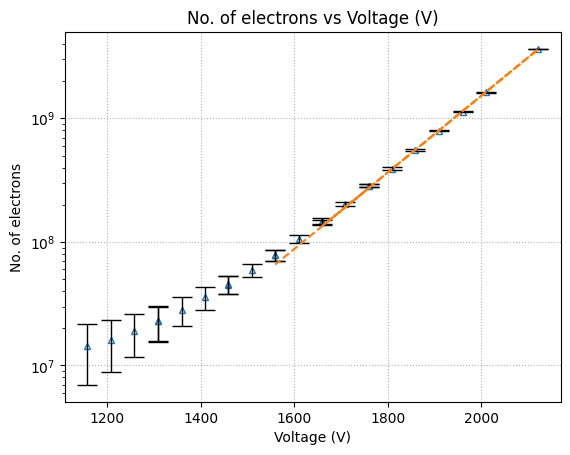

In [1300]:
log_no_e_list_fe=np.log(no_e_list_fe)
p0_fe=np.polyfit(file_labels,log_no_e_list,1)
exp_fit_fe=sci.curve_fit(exponential,file_labels_fe,no_e_list_fe,p0=p0_fe)
s_fe,t_fe=exp_fit_fe[0][0],exp_fit_fe[0][1]
fit_exp_fe=[exponential(file_labels_fe[i],s_fe,t_fe) for i in range(0,len(file_labels_fe))]

plt.plot(file_labels_fe,no_e_list_fe,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels_fe,no_e_list_fe,yerr=no_e_list_err_fe,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.plot(file_labels_fe[:-13],fit_exp_fe[:-13],linestyle='--')

plt.ylabel("No. of electrons")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("No. of electrons vs Voltage (V)")
plt.show()


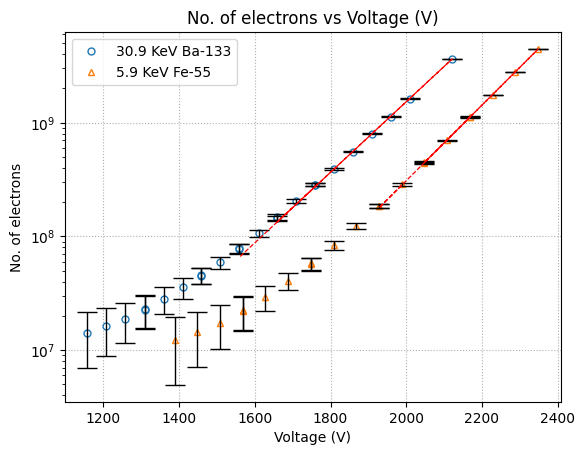

In [1301]:

plt.plot(file_labels_fe,no_e_list_fe,marker='o',ms=5,linestyle='None',fillstyle='none',label='30.9 KeV Ba-133')
plt.errorbar(file_labels_fe,no_e_list_fe,yerr=no_e_list_err_fe,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.plot(file_labels_fe[:-13],fit_exp_fe[:-13],linestyle='--',color='red',linewidth='0.9')

plt.plot(file_labels,no_e_list,marker='^',ms=5,linestyle='None',fillstyle='none',label='5.9 KeV Fe-55')
plt.errorbar(file_labels,no_e_list,yerr=no_e_list_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--',color='red',linewidth='0.9')

plt.ylabel("No. of electrons")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("No. of electrons vs Voltage (V)")
plt.legend()
plt.show()


In [1302]:
def gas_multiplication_factor(charge_cent,No):
    e=1.6e-19
    return [charge_cent[i]/(No*e) for i in range(0,len(charge_cent))]

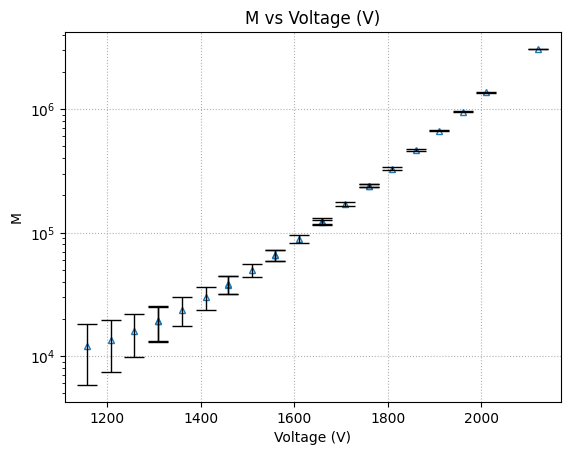

[np.float64(238583.25339389418), np.float64(329691.18170971394), np.float64(467694.79742394405), np.float64(667820.149789234), np.float64(949411.358427322), np.float64(1361700.6263925296), np.float64(3051759.5880053765), np.float64(124569.02656487831), np.float64(171010.68872636402), np.float64(239387.03976036338), np.float64(65659.77778720304), np.float64(89053.9093367085), np.float64(120729.07459908268), np.float64(37884.78293756362), np.float64(49479.7979726638), np.float64(65447.750623330954), np.float64(19330.28170346853), np.float64(23704.849797723706), np.float64(29815.13229837115), np.float64(38195.045864731124), np.float64(11979.10913098055), np.float64(13613.386515936907), np.float64(15875.210754256123), np.float64(19046.45341080592)]


In [1303]:

gas_mult_list_fe=gas_multiplication_factor(charge_cali_cents_fe,n_o_fe)
gas_mult_err_fe=gas_multiplication_factor(charge_cali_err_fe,n_o_fe)
plt.plot(file_labels_fe,gas_mult_list_fe,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels_fe,gas_mult_list_fe,yerr=gas_mult_err_fe,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
# plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')
plt.ylabel("M")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("M vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.show()
print(gas_mult_list_fe)

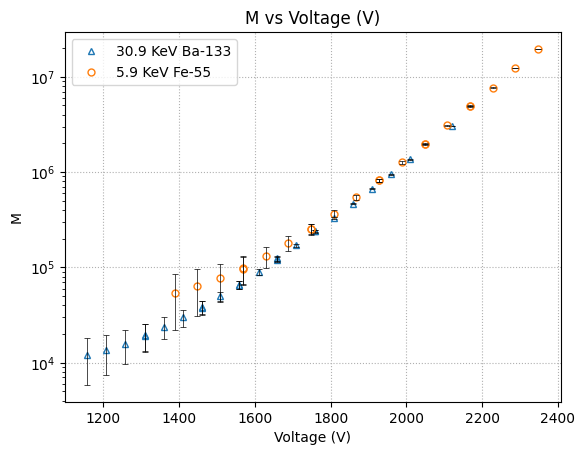

In [1304]:
plt.plot(file_labels_fe,gas_mult_list_fe,marker='^',ms=5,linestyle='None',fillstyle='none',label='30.9 KeV Ba-133')
plt.errorbar(file_labels_fe,gas_mult_list_fe,yerr=gas_mult_err_fe,linestyle='none',color='black', capsize=2, capthick=0.5,elinewidth=0.5)
plt.plot(file_labels,gas_mult_list,marker='o',ms=5,linestyle='None',fillstyle='none',label='5.9 KeV Fe-55')
plt.errorbar(file_labels,gas_mult_list,yerr=gas_mult_err,linestyle='none',color='black', capsize=2, capthick=0.5,elinewidth=0.5)
# plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')
plt.ylabel("M")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("M vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.legend()
plt.show()

In [1305]:
# def calculate_ln_M(V_array, b, a, delta_V, p, K):
#     import math
#     """
#     Calculate ln M for an array of voltage values using the equation:
#     ln M = V / ln(b/a) * (ln 2 / ΔV) * ln(V / (p * a * ln(b/a) * K))
    
#     Parameters:
#     -----------
#     V_array : numpy array or list
#         Array of voltage values (volts)
#     b : float
#         Outer radius (mm or cm)
#     a : float
#         Inner radius (same units as b)
#     delta_V : float
#         Voltage difference (volts)
#     p : float
#         Pressure (e.g., atm, bar, Pa)
#     K : float
#         Constant
    
#     Returns:
#     --------
#     ln_M_array : numpy array
#         Array of ln M values for each voltage
#     """
#     # Convert to numpy array if it's a list
#     V_array = np.array(V_array, dtype=float)
    
#     # Calculate ln(b/a) - constant for all voltages
#     ln_ba = math.log(b / a)
    
#     # Calculate the constant factor outside the parentheses
#     const_factor = (math.log(2) / delta_V) / ln_ba
    
#     # Calculate the argument for the logarithm
#     # V / (p * a * ln_ba * K)
#     log_arg_denominator = p * a * ln_ba * K
    
#     # Calculate ln M for each voltage
#     ln_M_array = V_array * const_factor * np.log(V_array / log_arg_denominator)
#     M_array=np.exp(ln_M_array)
#     return ln_M_array,M_array

# ln_M_fe,M_fe=calculate_ln_M(file_labels, b, a, delta_V_fe, p, K_val)
# ln_M_ba,M_ba=calculate_ln_M(file_labels_fe, b, a, delta_V_ba, p, K_val)
# plt.plot(file_labels,M_fe,'r.')
# plt.plot(file_labels_fe,M_ba,'b.')

In [1306]:
def ln_M_func(V,b,a,delta_V,p,k):
    # ln_M=(V*np.log(2))/(np.log(b/a)*delta_V)*(np.log(V/(p*a*np.log(b/a)))-np.log(k))
    ln_M=(V*np.log(2))*(np.log(V/(p*a*k*np.log(b/a))))/(np.log(b/a)*delta_V)
    M_vals=np.exp(ln_M)
    return ln_M, M_vals

100


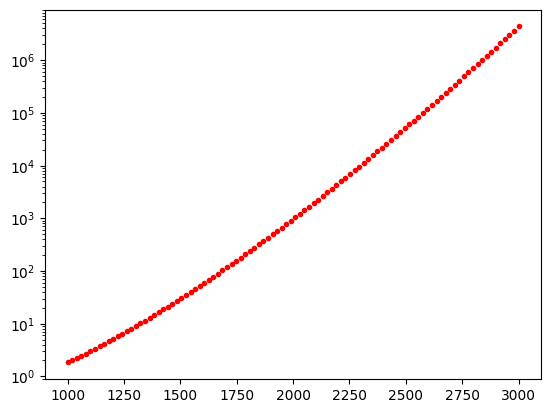

In [1307]:
b=(66e-1)/2
a=(50e-4)/2
delta_V=23.6
p=1
K_val=4.8e4
ln_M_list=[]
M_list=[]
#######
ln_M_list_th=[]
M_list_th=[]

theory_v_range=np.linspace(1000,3000,100)

for i in range(0,len(theory_v_range)):
    ln_M_th,M_vals_th=ln_M_func(theory_v_range[i], b, a, delta_V, p, K_val)
    ln_M_list_th.append(ln_M_th)
    M_list_th.append(M_vals_th)
    
print(len(M_list_th))


plt.plot(theory_v_range,M_list_th,'r.')
plt.yscale('log')
plt.show()
    
########
# for i in range(0,len(file_labels)):
#     ln_M,M_vals=ln_M_func(file_labels[i], b, a, delta_V, p, K_val)
#     ln_M_list.append(ln_M)
#     M_list.append(M_vals)

# plt.plot(file_labels,M_list,'r.')
# plt.yscale('log')
# plt.show()

# print(ln_M_list)
# print(file_labels)
# print(file_labels_fe)

# plt.plot(file_labels,ln_M_list,'b.')

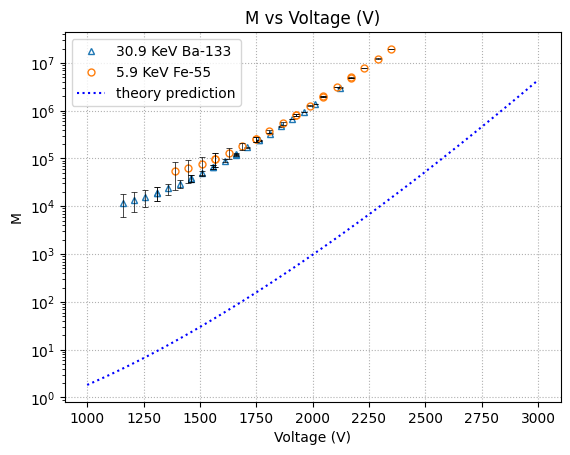

In [1310]:
plt.plot(file_labels_fe,gas_mult_list_fe,marker='^',ms=5,linestyle='None',fillstyle='none',label='30.9 KeV Ba-133')
plt.errorbar(file_labels_fe,gas_mult_list_fe,yerr=gas_mult_err_fe,linestyle='none',color='black', capsize=2, capthick=0.5,elinewidth=0.5)
plt.plot(file_labels,gas_mult_list,marker='o',ms=5,linestyle='None',fillstyle='none',label='5.9 KeV Fe-55')
plt.errorbar(file_labels,gas_mult_list,yerr=gas_mult_err,linestyle='none',color='black', capsize=2, capthick=0.5,elinewidth=0.5)
# plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')
# plt.plot(file_labels,M_list,'r.',label='theoretical prediction')
plt.plot(theory_v_range,M_list_th,color='blue',linestyle=':',label='theory prediction')
plt.ylabel("M")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("M vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.legend()
plt.show()